In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats
import corner
import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc

In [2]:
x = np.load('../../solutions/transient.npy')
time = x[:,0]
flux = x[:,1]
df = x[:,2]

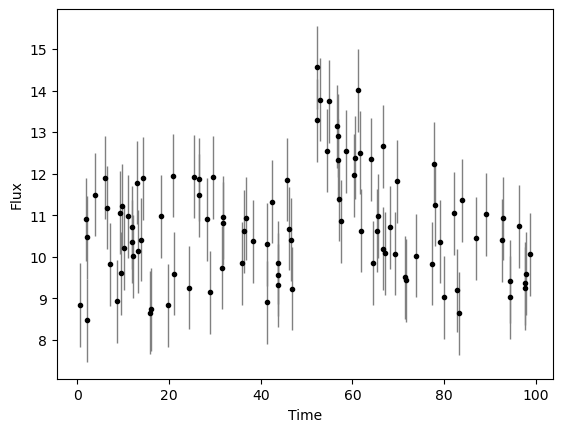

In [3]:
plt.errorbar(time, flux, df, fmt='.k', lw=1, ecolor='gray')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.show()

In [4]:
def burst(time, theta):
    A, b, t0, alpha = theta
    return np.where(time<t0, b, b+A*np.exp(-alpha*(time-t0)))

def gaussian(time, theta):
    A, b, t0, sigma = theta
    return b + A*np.exp(-((time-t0)**2)/(2*(sigma**2)))

## Fit by eye

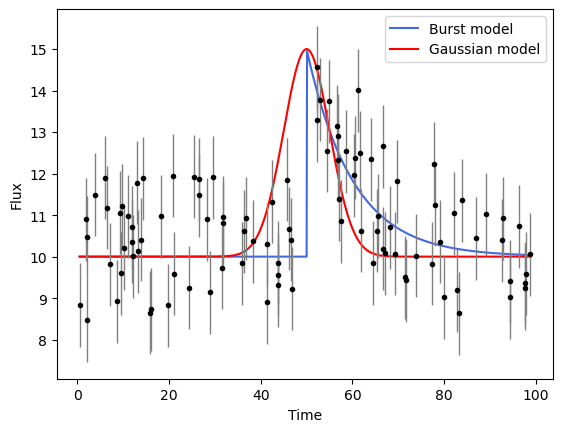

In [24]:
A_eye = 5
b_eye = 10
t0_eye = 50
alpha_eye = 0.1
sigma_eye = 5
theta_eye_burst = [A_eye, b_eye, t0_eye, alpha_eye]
theta_eye_gaussian = [A_eye, b_eye, t0_eye, sigma_eye]

time_grid = np.linspace(time.min(), time.max(), 1000)

plt.plot(time_grid, burst(time_grid, theta_eye_burst), color = 'royalblue', label = 'Burst model')
plt.plot(time_grid, gaussian(time_grid, theta_eye_gaussian), color = 'red', label = 'Gaussian model')
plt.errorbar(time, flux, df, fmt='.k', lw=1, ecolor='gray')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.legend()
plt.show()

In [15]:
A_min, A_max = 0, 50
b_min, b_max = 0, 50
t0_min, t0_max = 0, 100
alpha_min, alpha_max = np.exp(-5), np.exp(5)
sigma_min, sigma_max = 1, 20
labels_burst = ['A', 'b', r'$t_0$', r'$\alpha$']
labels_gaussian = ['A', 'b', r'$t_0$', r'$\sigma_{w}$']

In [16]:
def LogLikelihood(theta, df, flux, model):
    if model == 'burst':
        y_fit = burst(time, theta)
    if model == 'gaussian':
        y_fit = gaussian(time, theta)
    return -0.5 * np.sum((flux-y_fit)**2 / df**2) 

def prior(u, model):
    param = np.copy(u)
    param[0] = scipy.stats.uniform.ppf(u[0], loc = A_min, scale = A_max-A_min)
    param[1] = scipy.stats.uniform.ppf(u[1], loc = b_min, scale = b_max-b_min)
    param[2] = scipy.stats.uniform.ppf(u[2], loc = t0_min, scale = t0_max-t0_min)
    if model == 'burst':
        param[3] = scipy.stats.loguniform.ppf(u[3], alpha_min, alpha_max)
    if model == 'gaussian':
        param[3] = scipy.stats.uniform.ppf(u[3], loc = sigma_min, scale = sigma_max-sigma_min)
    return param

## Nested sampling with burst model

In [8]:
ndim = 4
sampler_burst = dynesty.NestedSampler(LogLikelihood, prior, ndim, logl_args=[df, flux, 'burst'], ptform_args=['burst'], nlive = 500)
sampler_burst.run_nested()
sresults_burst = sampler_burst.results

C:\Users\restu\AppData\Local\Temp\ipykernel_9900\3211962886.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(time<t0, b, b+A*np.exp(-alpha*(time-t0)))
C:\Users\restu\AppData\Local\Temp\ipykernel_9900\3211962886.py:3: RuntimeWarning: overflow encountered in multiply
  return np.where(time<t0, b, b+A*np.exp(-alpha*(time-t0)))
1866it [00:15, 44.04it/s, bound: 0 | nc: 27 | ncall: 18539 | eff(%): 10.065 | loglstar:   -inf < -182.300 <    inf | logz: -191.191 +/-  0.128 | dlogz: 108.698 >  0.509]    C:\Users\restu\AppData\Local\Temp\ipykernel_9900\3211962886.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(time<t0, b, b+A*np.exp(-alpha*(time-t0)))
C:\Users\restu\AppData\Local\Temp\ipykernel_9900\3211962886.py:3: RuntimeWarning: overflow encountered in multiply
  return np.where(time<t0, b, b+A*np.exp(-alpha*(time-t0)))
1938it [00:16, 69.52it/s, bound: 1 | nc: 29 | ncall: 19496 | eff(%):  9.941 | loglstar:   -inf < -162.638 <    inf | logz: -171.251 +/-  

#### Runplot

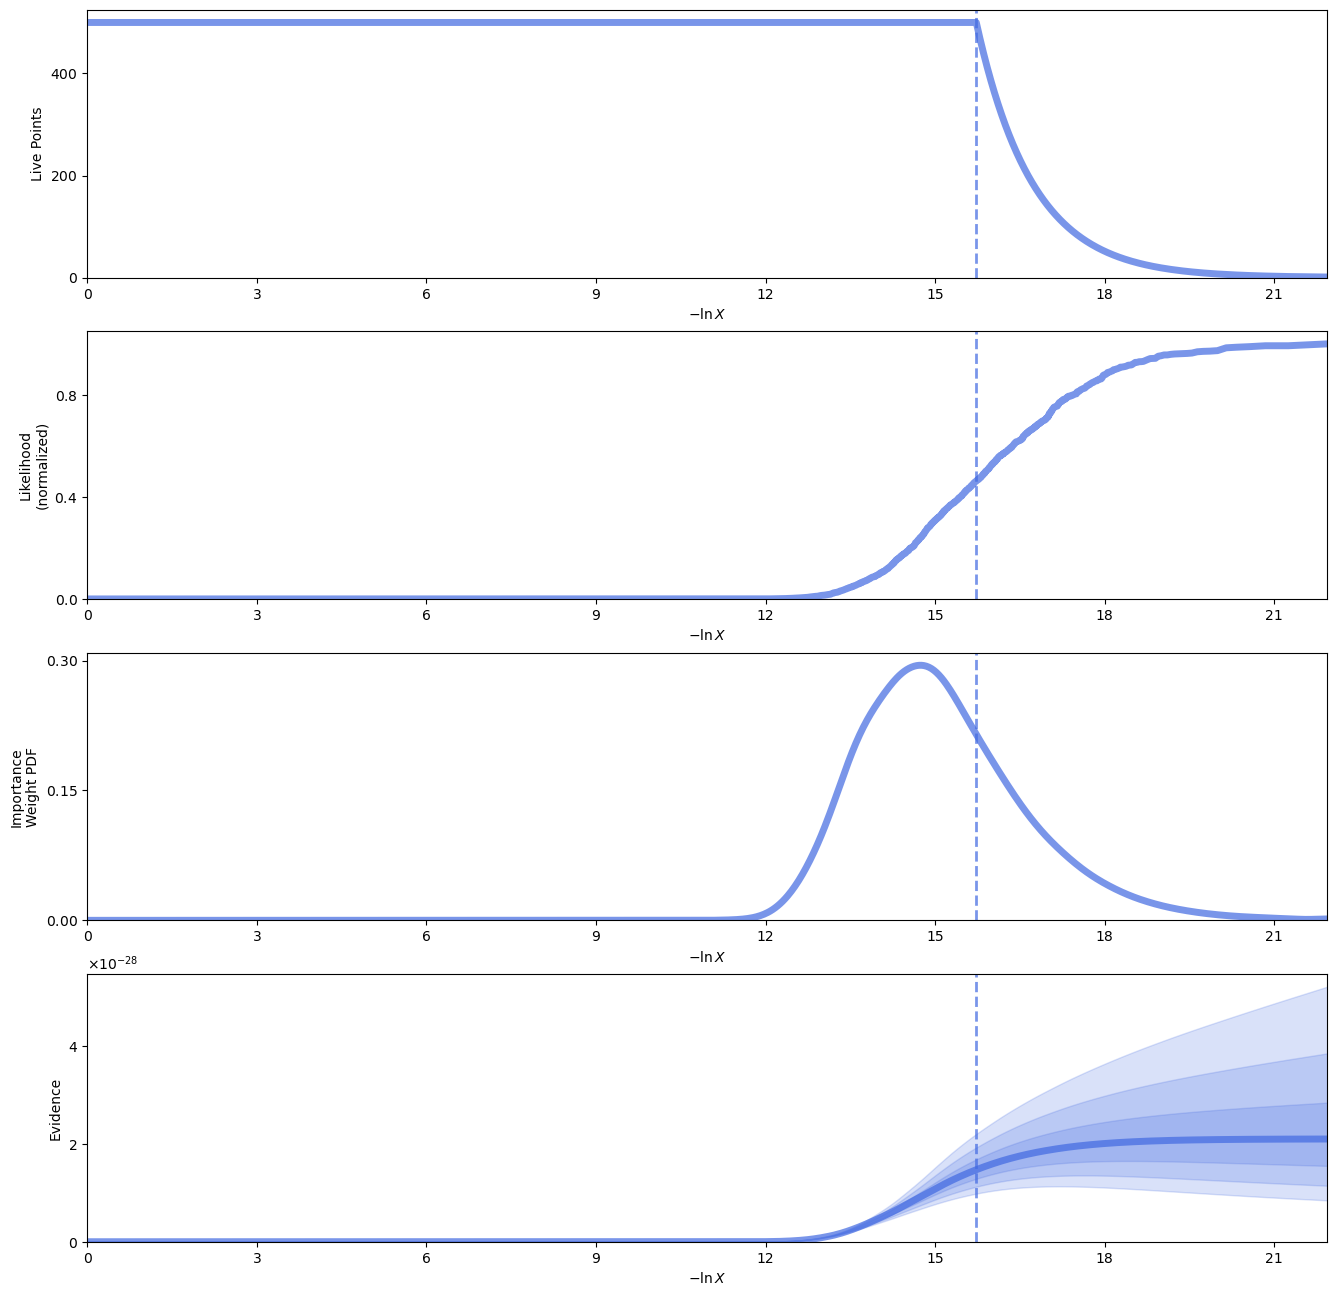

In [9]:
rfig_burst, raxes_burst = dyplot.runplot(sresults_burst, color = 'royalblue')

#### Traceplot

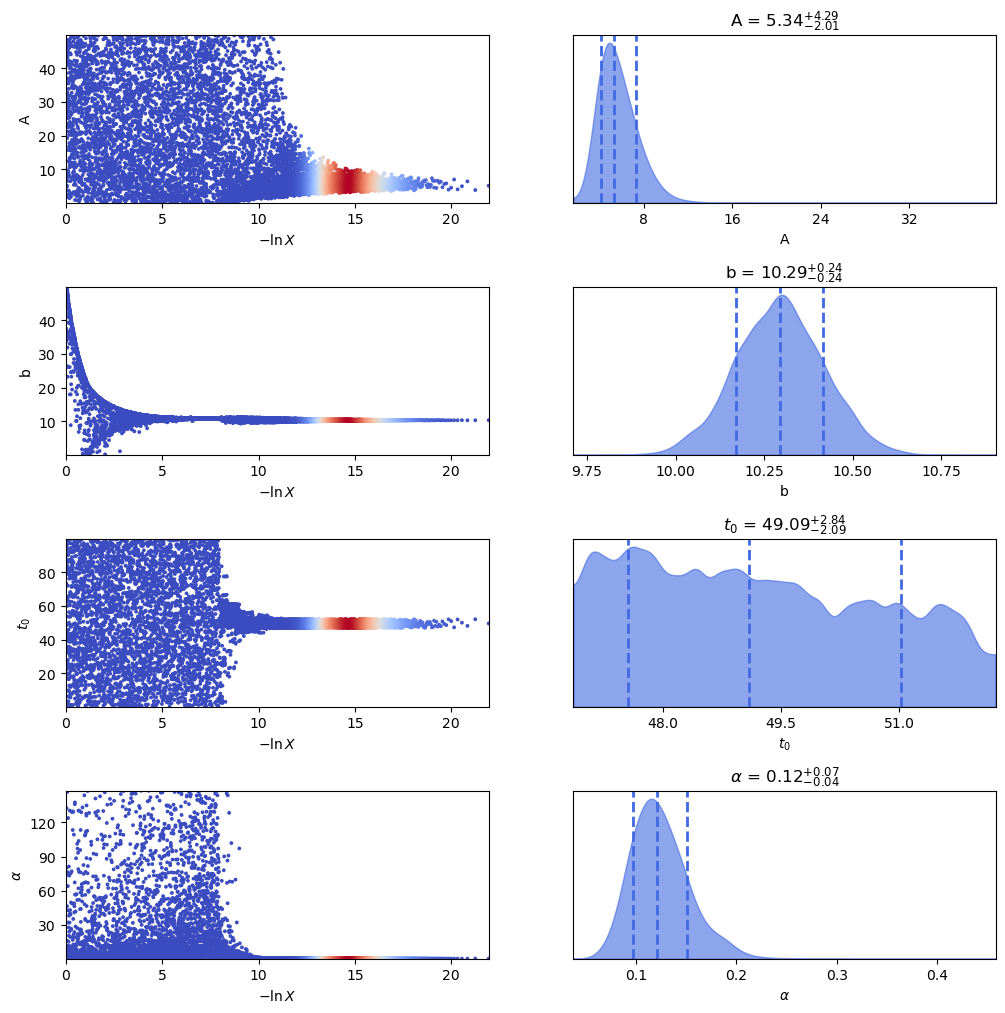

In [10]:
tfig_burst, taxes_burst = dyplot.traceplot(sresults_burst, labels = labels_burst, post_color='royalblue', trace_cmap='coolwarm', show_titles=True, quantiles=[0.16, 0.5, 0.84])
plt.subplots_adjust(hspace=0.5)

#### Cornerplots

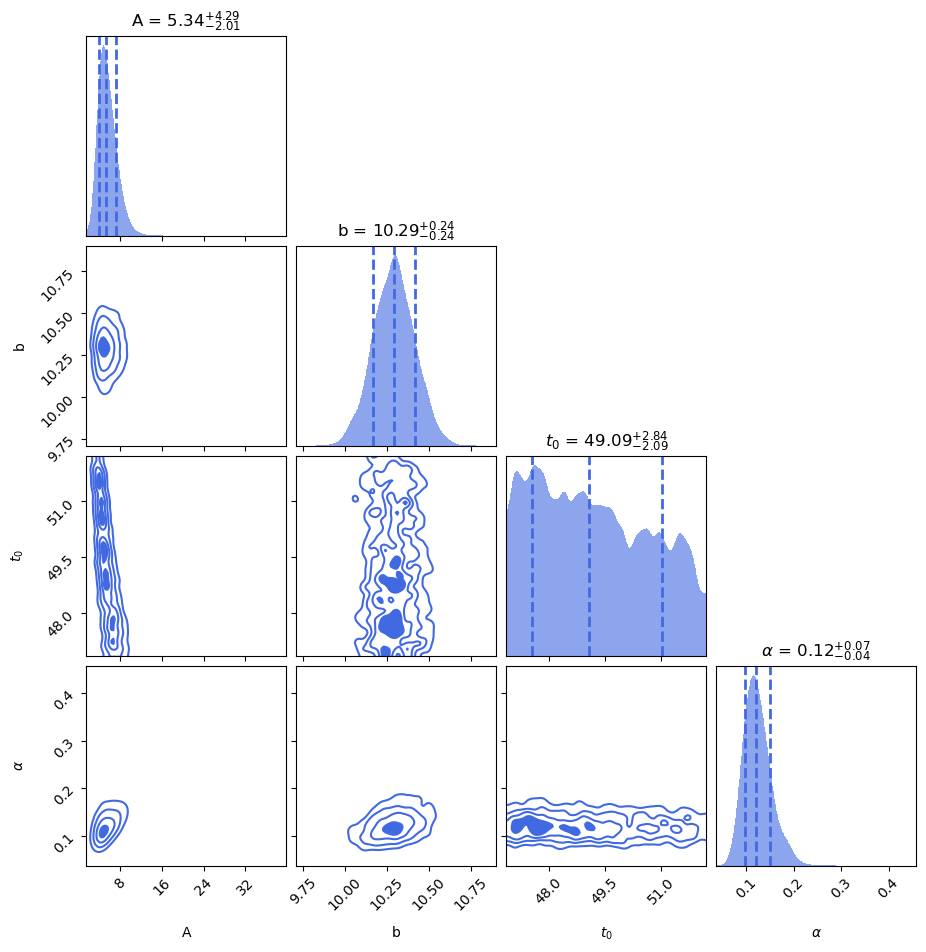

In [11]:
cfig_burst, caxes_burst = dyplot.cornerplot(sresults_burst, labels = labels_burst, quantiles=[0.16, 0.5, 0.84], show_titles=True, color = 'royalblue')

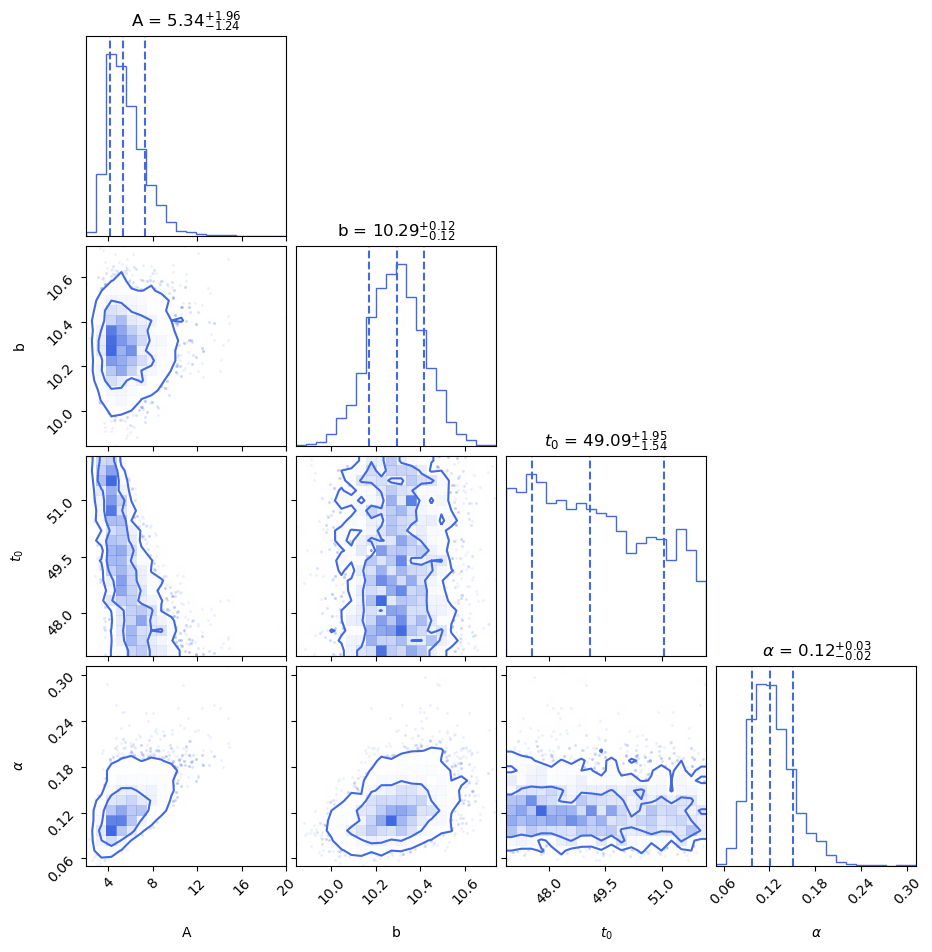

In [12]:
samples_burst = sresults_burst.samples  # samples
weights_burst = np.exp(sresults_burst.logwt - sresults_burst.logz[-1])
samples_burst_equal = dyfunc.resample_equal(samples_burst, weights_burst)
corner.corner(samples_burst_equal, labels=labels_burst, levels=[0.68,0.95], show_titles=True, quantiles=[0.16, 0.5, 0.84], color = 'royalblue');

In [13]:
evidence_burst = sresults_burst.logz[-1] #evidence
print("Bayesian evidence", np.exp(evidence_burst))

# Compute 10%-90% quantiles.
quantiles_burst = [dyfunc.quantile(samps, [0.16, 0.84], weights=weights_burst)
             for samps in samples_burst.T]
print('68% parameter credible regions are:\n ' + str(quantiles_burst) + '\n')

# Compute weighted mean and covariance.
mean_burst, cov_burst = dyfunc.mean_and_cov(samples_burst, weights_burst)
print('Mean and covariance of parameters are: ' + str(mean_burst) + '\n' + str(cov_burst))

Bayesian evidence 2.0979529338246815e-28
68% parameter credible regions are:
 [[4.10263143818588, 7.312717732511036], [10.169729988549802, 10.41628059932619], [47.55533279308777, 51.02839632696812], [0.09688436256024568, 0.15096040624491128]]

Mean and covariance of parameters are: [ 5.67264174 10.29369456 49.23389991  0.12445657]
[[ 2.76161559e+00  1.01897662e-02 -1.66142506e+00  2.79582786e-02]
 [ 1.01897662e-02  1.50914951e-02  6.08179594e-04  1.34105439e-03]
 [-1.66142506e+00  6.08179594e-04  2.23328120e+00 -1.56598784e-03]
 [ 2.79582786e-02  1.34105439e-03 -1.56598784e-03  8.20895791e-04]]


## Nested sampling with gaussian model

In [17]:
ndim = 4
sampler_gaussian = dynesty.NestedSampler(LogLikelihood, prior, ndim, logl_args=[df, flux, 'gaussian'], ptform_args=['gaussian'], nlive = 500)
sampler_gaussian.run_nested()
sresults_gaussian = sampler_gaussian.results

2077it [00:15, 107.42it/s, bound: 2 | nc: 28 | ncall: 19176 | eff(%): 10.831 | loglstar:   -inf < -424.542 <    inf | logz: -434.891 +/-  0.136 | dlogz: 358.049 >  0.509]   C:\Users\restu\anaconda3\Lib\site-packages\dynesty\bounding.py:618: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
2200it [00:20, 17.66it/s, bound: 6 | nc: 87 | ncall: 21829 | eff(%): 10.078 | loglstar:   -inf < -350.570 <    inf | logz: -359.763 +/-  0.130 | dlogz: 291.178 >  0.509] C:\Users\restu\anaconda3\Lib\site-packages\dynesty\bounding.py:618: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are usin

#### Runplot

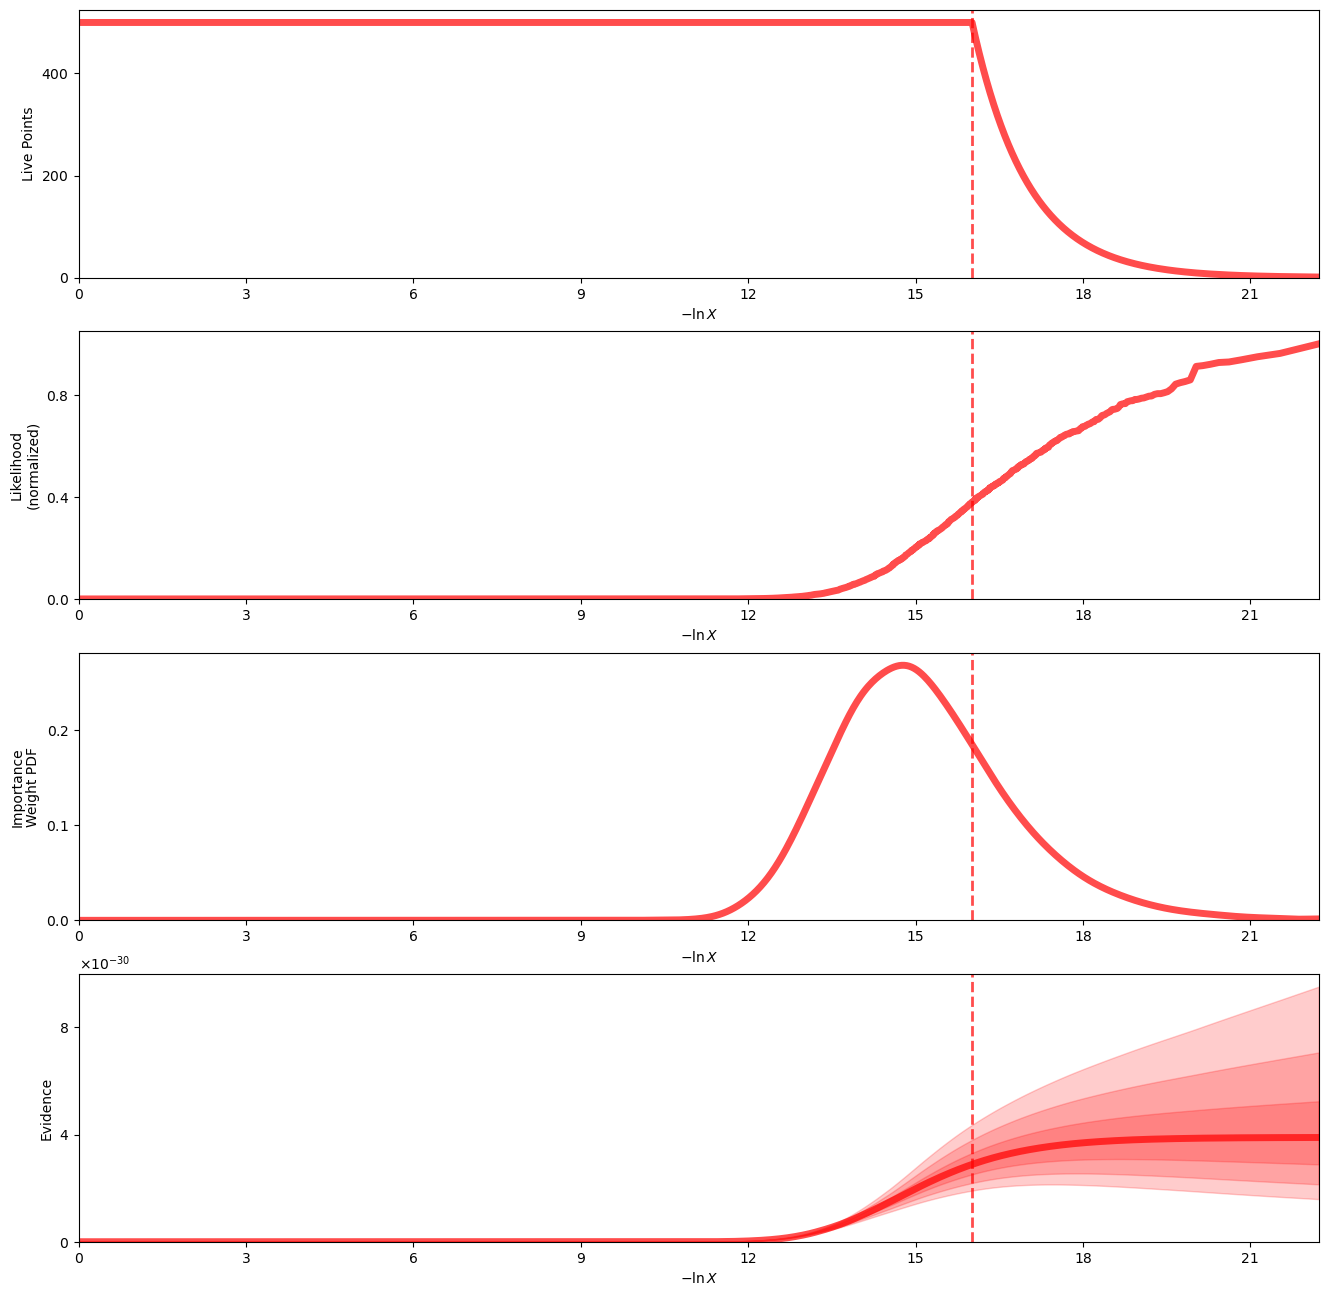

In [18]:
rfig_gaussian, raxes_gaussian = dyplot.runplot(sresults_gaussian, color = 'red')

#### Traceplot

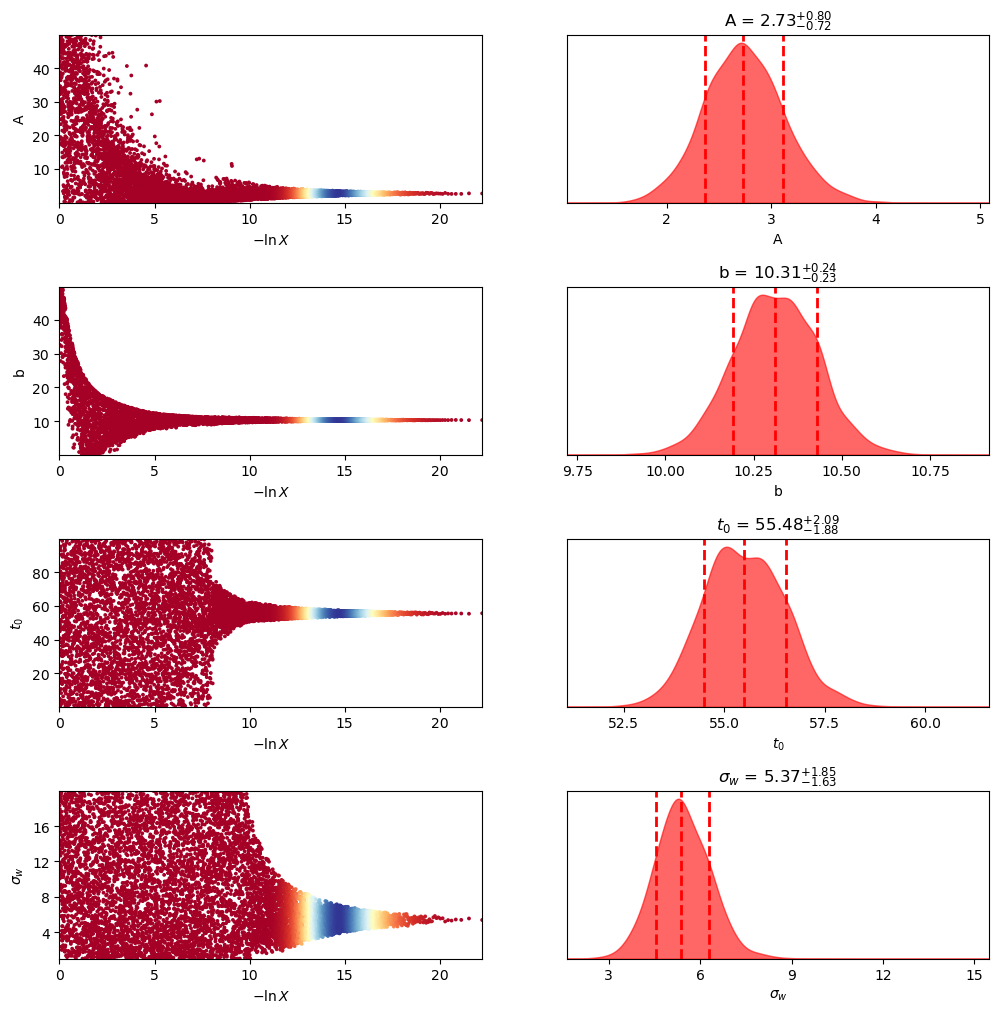

In [26]:
tfig_gaussian, taxes_gaussian = dyplot.traceplot(sresults_gaussian, labels = labels_gaussian, post_color='red', trace_cmap='RdYlBu', show_titles=True, quantiles=[0.16, 0.5, 0.84])
plt.subplots_adjust(hspace=0.5)

#### Cornerplots

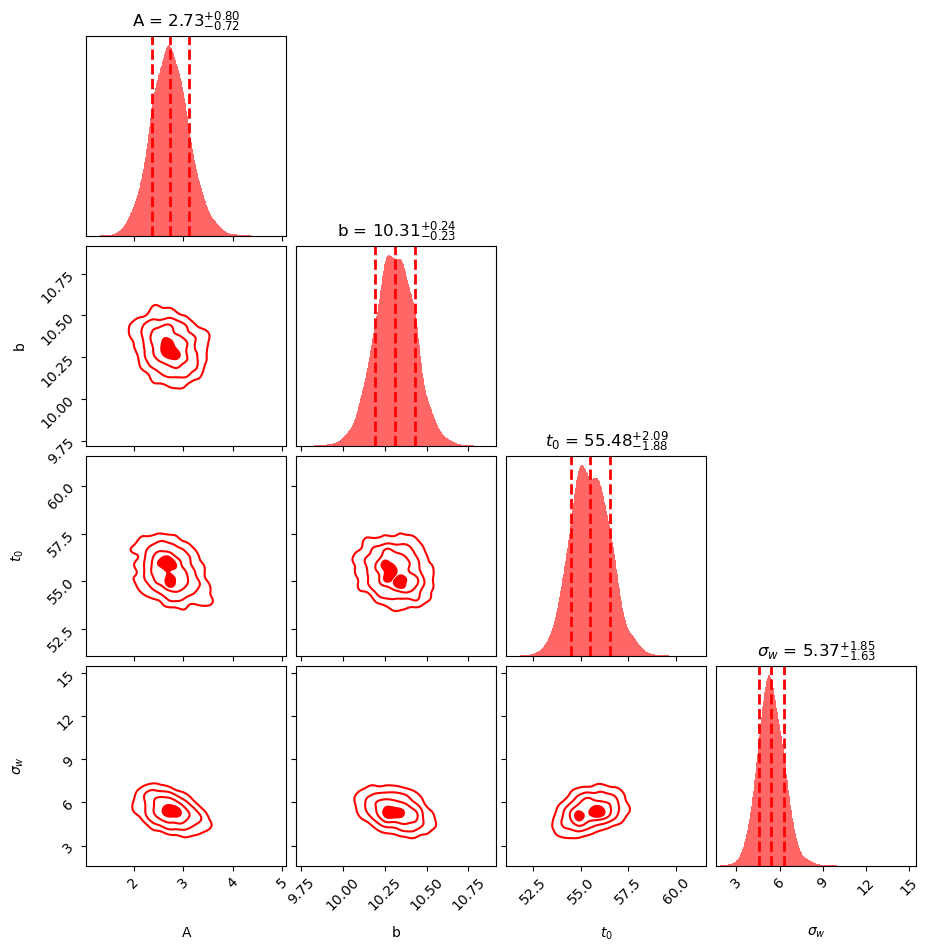

In [20]:
cfig_gaussian, caxes_gaussian = dyplot.cornerplot(sresults_gaussian, labels = labels_gaussian, quantiles=[0.16, 0.5, 0.84], show_titles=True, color = 'red')

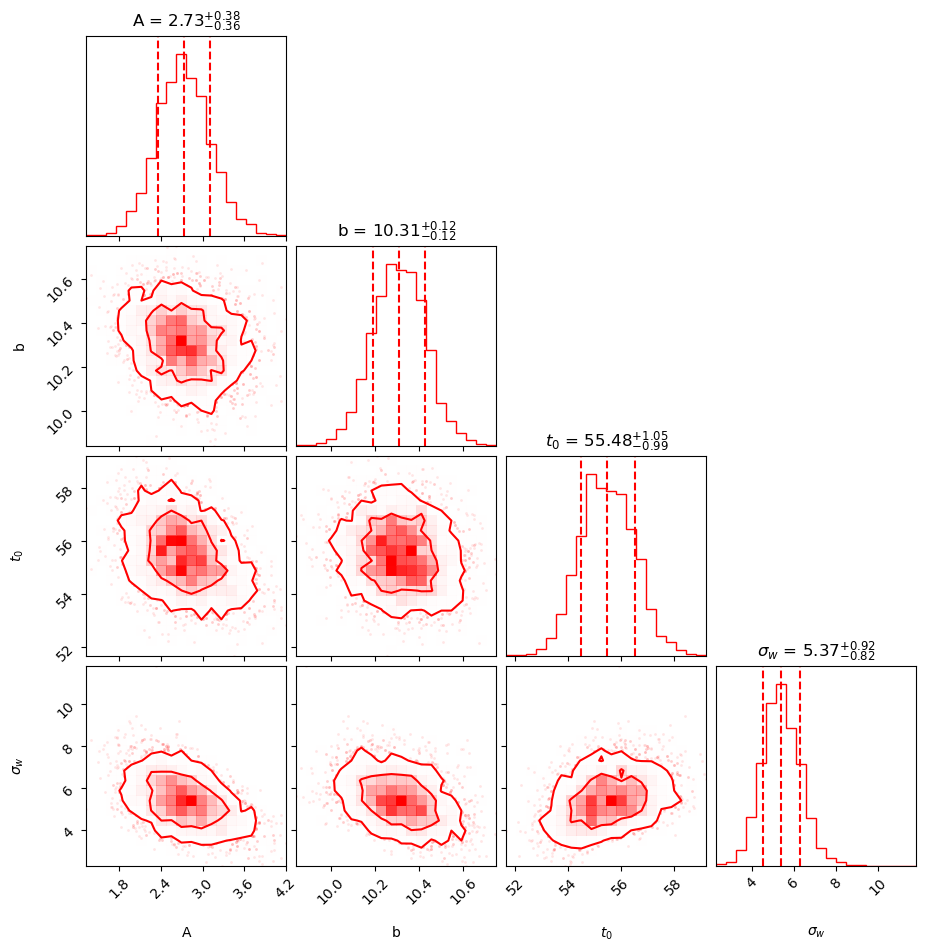

In [21]:
samples_gaussian = sresults_gaussian.samples  # samples
weights_gaussian = np.exp(sresults_gaussian.logwt - sresults_gaussian.logz[-1])
samples_gaussian_equal = dyfunc.resample_equal(samples_gaussian, weights_gaussian)
corner.corner(samples_gaussian_equal, labels=labels_gaussian, levels=[0.68,0.95], show_titles=True, quantiles=[0.16, 0.5, 0.84], color = 'red');

In [22]:
evidence_gaussian = sresults_gaussian.logz[-1] #evidence
print("Bayesian evidence", np.exp(evidence_gaussian))

# Compute 10%-90% quantiles.
quantiles_gaussian = [dyfunc.quantile(samps, [0.16, 0.84], weights=weights_gaussian)
             for samps in samples_gaussian.T]
print('68% parameter credible regions are:\n ' + str(quantiles_gaussian) + '\n')

# Compute weighted mean and covariance.
mean_gaussian, cov_gaussian = dyfunc.mean_and_cov(samples_gaussian, weights_gaussian)
print('Mean and covariance of parameters are: ' + str(mean_gaussian) + '\n' + str(cov_gaussian))

Bayesian evidence 3.8914688782133985e-30
68% parameter credible regions are:
 [[2.364078320500957, 3.1071754640364304], [10.191454560562741, 10.428695517540222], [54.49476527100751, 56.53103449798941], [4.557874589420778, 6.291712941708425]]

Mean and covariance of parameters are: [ 2.73797361 10.31037123 55.50275907  5.42057964]
[[ 0.1451739  -0.0095133  -0.12806323 -0.14984407]
 [-0.0095133   0.01417657 -0.02077549 -0.04062672]
 [-0.12806323 -0.02077549  1.01731147  0.30778271]
 [-0.14984407 -0.04062672  0.30778271  0.80131132]]


## Model comparison

In [34]:
print('Burst model summary:')
sresults_burst.summary()
print('\nGaussian model summary:')
sresults_gaussian.summary()

Burst model summary:
Summary
nlive: 500
niter: 7872
ncall: 159861
eff(%):  5.237
logz: -63.731 +/-  0.303

Gaussian model summary:
Summary
nlive: 500
niter: 8014
ncall: 64389
eff(%): 13.223
logz: -67.719 +/-  0.298


## Bayes factor

In [35]:
print('The logarithmic Bayes factor is: ', np.log(np.exp(sresults_burst.logz[-1])/np.exp(sresults_gaussian.logz[-1])))

The logarithmic Bayes factor is:  3.987345571870698


## capisci perchè ti esce così basso e vedi se fare qualche istogramma della posterior di qualche parametro